In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import json
import os

from minigraphs import io
from minigraphs import visualization as viz
from importlib import reload 

reload(io)


from matplotlib.lines import Line2D
DATA_DIR = '/mnt/home/martjor/repos/dev_pt/data'


# Network Datasets

In [2]:

# Load Data
graph_names = ["hamsterster",
               "econ-poli",
               "soc-pages-tvshow",
               "f-socfb-nips-ego",
               "inf-roadNET-PA"]

metrics_giants = []
for name in graph_names:
    with open(os.path.join(DATA_DIR,'networks','giant_' + name,'metrics.json'),'r') as file:
        temp_dict = json.load(file)
        
    metrics_giants.append(pd.Series(temp_dict))
    
metrics_giants = pd.concat(metrics_giants,keys=graph_names,axis=1).T
metrics_giants
    

,n_vertices,n_edges,density,assortativity,assortativity_norm,clustering
hamsterster,2000.0,16097.0,0.008053,0.022722,0.511361,0.539978
econ-poli,2343.0,5010.0,0.001826,-0.169480,0.415260,0.067406
soc-pages-tvshow,3892.0,17262.0,0.002280,0.560355,0.780178,0.373738
f-socfb-nips-ego,2888.0,2981.0,0.000715,-0.668214,0.165893,0.027247
inf-roadNET-PA,1087562.0,1541514.0,0.000003,0.121989,0.560994,0.046463


/tmp/ipykernel_881796/3395866879.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Set1",df.shape[0])


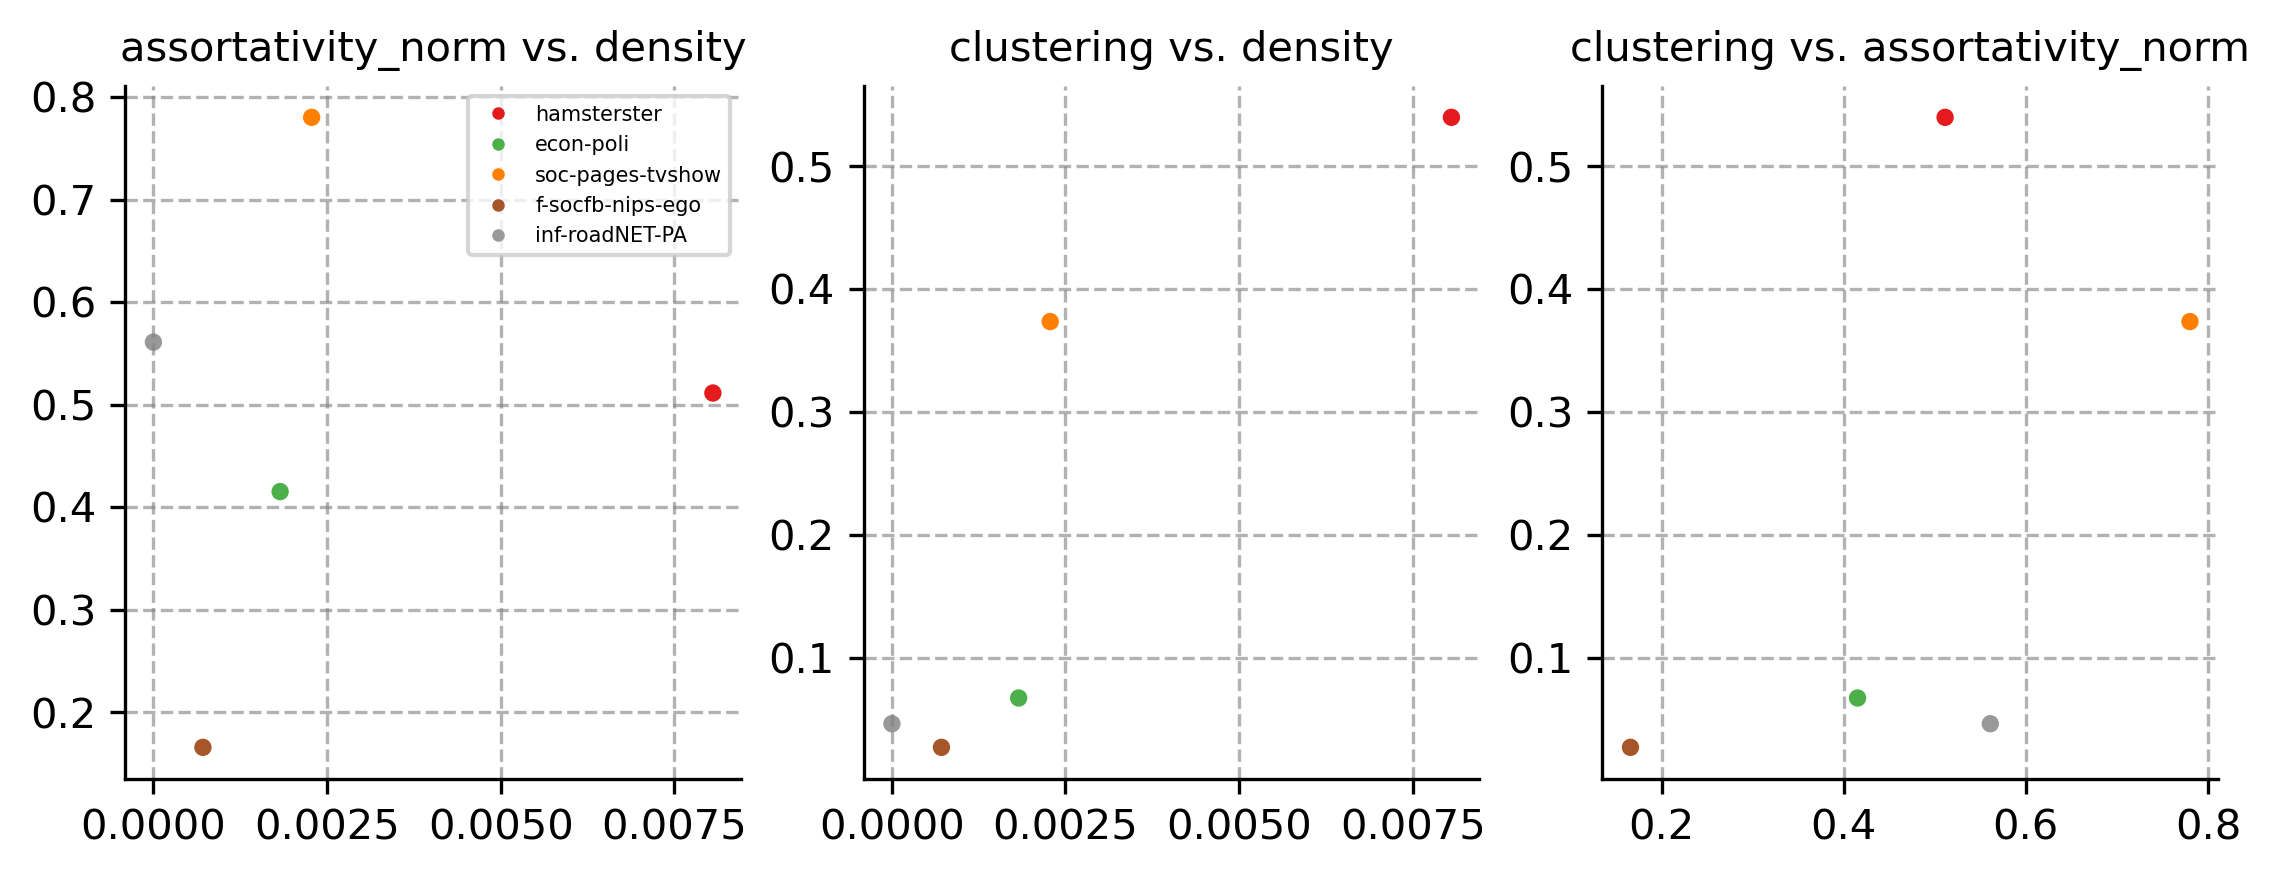

In [3]:
from itertools import combinations
from scipy.special import comb
import matplotlib.cm as cm 
from matplotlib.lines import Line2D

matplotlib.rc_file('../minigraphs_rc')

metrics_names = ["density","assortativity_norm","clustering"]
def pair_plot(df,metrics_names):
    cmap = cm.get_cmap("Set1",df.shape[0])
    pairs = combinations(metrics_names,2)
    n = int(comb(len(metrics_names),2))
    
    fig, axes = plt.subplots(1,n,figsize=(3*n,3))
    
    for i,pair in enumerate(pairs):
        axes[i].scatter(df[pair[0]],df[pair[1]],s=10,c=np.arange(df.shape[0]),cmap="Set1")
        plt.subplots_adjust(hspace=0.4)
        
        axes[i].set_title(f"{pair[1]} vs. {pair[0]}")
        
    
    custom_lines = [
        Line2D([0], [0], marker='o', lw=1.0),  # Example line 1 with blue color and linewidth 2
        Line2D([0], [0], color='red', lw=1.0)    # Example line 2 with red color and linewidth 3
    ]
    
    custom_markers = []
    for i in range(df.shape[0]):
        custom_markers.append(Line2D([0],[0],marker='o',color=cmap(i),linewidth=0,markersize=2))
    
    axes[0].legend(custom_markers,df.index.tolist())
    
    
        
axes = pair_plot(metrics_giants,
                 metrics_names)


    
    

# Miniaturization Assessment

## Feasibility

### Read Data

In [4]:
GRAPH_NAME = "giant_econ-poli"

# Load original graph data
with open(os.path.join(DATA_DIR,'networks',GRAPH_NAME,"metrics.json"),'r') as file:
    metrics_original = json.load(file)
print(json.dumps(metrics_original,indent=4))

# Load miniaturization data
reader = io.Reader(DATA_DIR)
reader.graph = GRAPH_NAME
miniatures = reader.list_miniatures()
metrics_miniatures, trajectories = reader.miniatures()
metrics_miniatures

{
    "n_vertices": 2343,
    "n_edges": 5010,
    "density": 0.0018260326652094854,
    "assortativity": -0.16948035997131428,
    "assortativity_norm": 0.41525982,
    "clustering": 0.06740572369463527
}
Pointing to giant_econ-poli at /mnt/home/martjor/repos/dev_pt/data/networks/giant_econ-poli



,Beta,Energy,density,assortativity_norm,clustering,err_density,err_assortativity_norm,err_clustering
600_2024-10-13_00,2.794655,0.150159,0.001826,0.415115,0.067407,0.001903,0.034934,0.001381
700_2024-10-13_00,2.527775,0.219215,0.001826,0.415240,0.067409,0.006168,0.004879,0.004891
800_2024-10-14_00,2.932669,0.592198,0.001826,0.415378,0.067408,0.021505,0.028522,0.003598
900_2024-10-14_00,2.766690,1.174855,0.001826,0.415840,0.067402,0.005257,0.139781,0.004922


### Process Data

In [5]:
# Calculate L2 error
columns = [column for column in metrics_miniatures.columns if "err_" in column]
print(columns)

metrics_miniatures['error'] = metrics_miniatures[columns].pow(2).sum(axis=1).apply(np.sqrt)
metrics_miniatures['error']

['err_density', 'err_assortativity_norm', 'err_clustering']


600_2024-10-13_00    0.035013
700_2024-10-13_00    0.009261
800_2024-10-14_00    0.035901
900_2024-10-14_00    0.139966
Name: error, dtype: float64

Text(0.5, 1.0, 'Average Clustering')

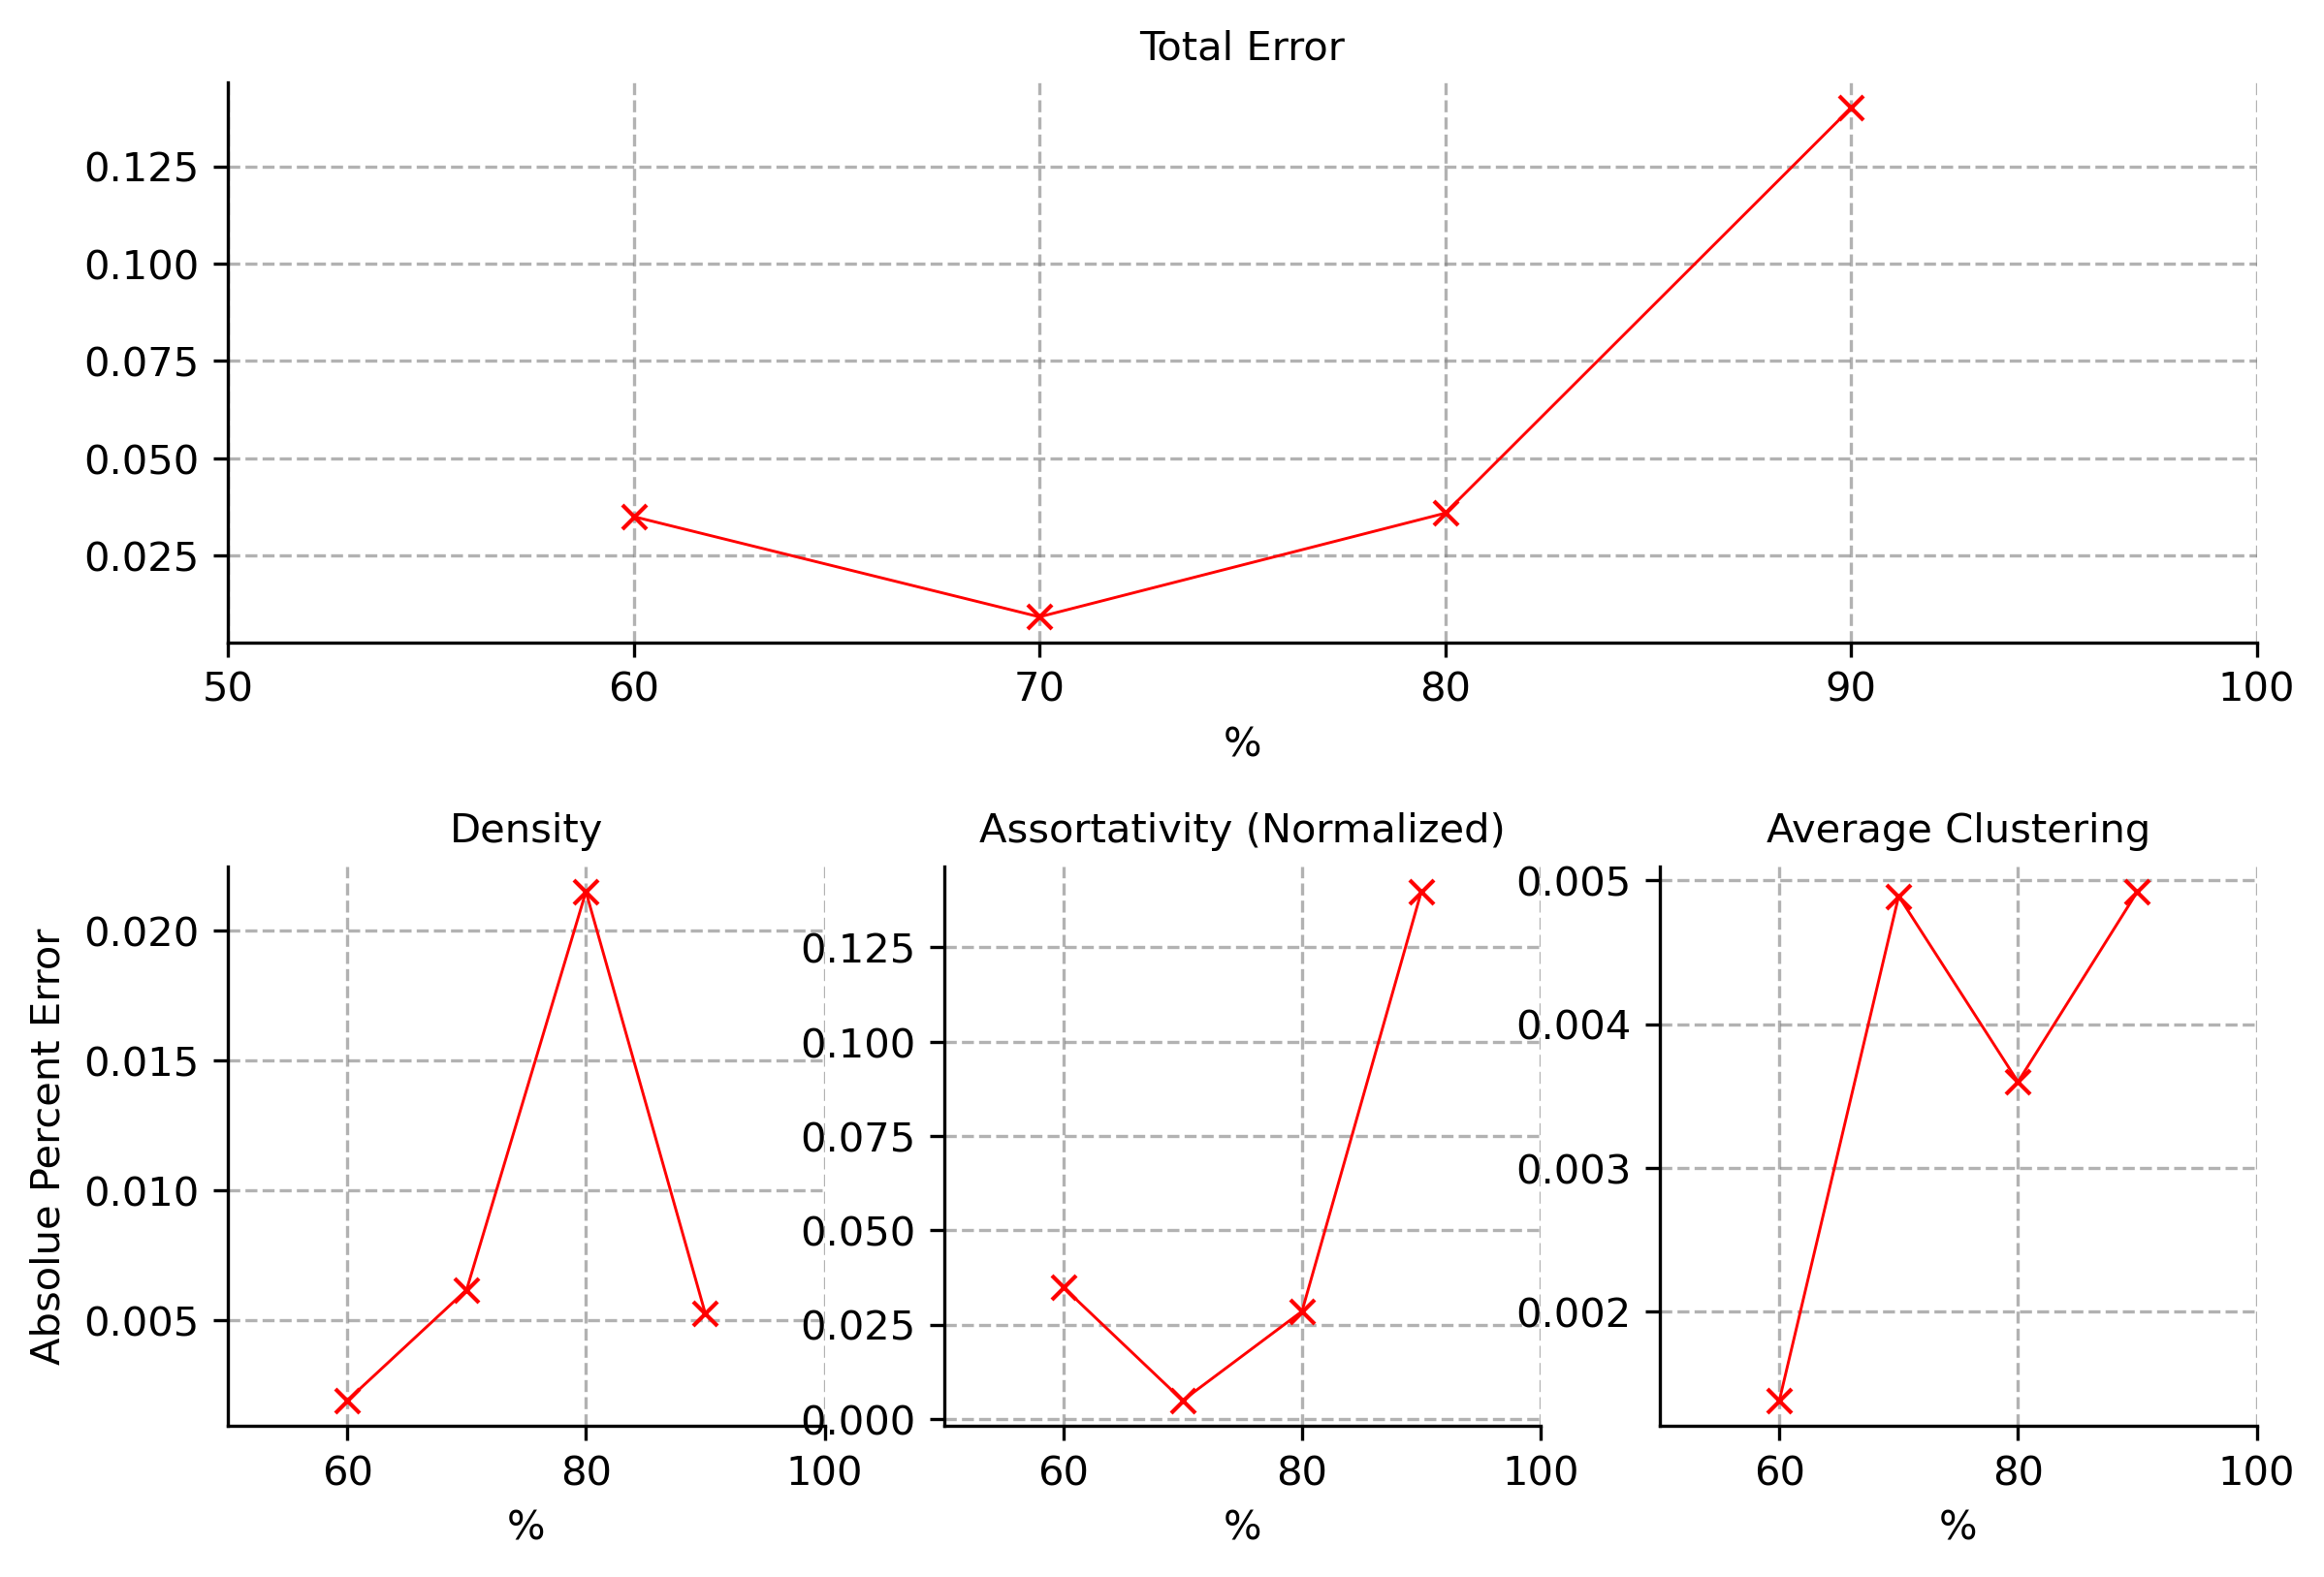

In [6]:
matplotlib.rc_file('../minigraphs_rc')

def plot_error(ax,y):
    scale = 10
    x = np.arange(6,10) * scale
    ax.plot(x,y,'-xr',linewidth=0.7)
    ax.set_xlim([x[0] - scale,scale * 10])
    
fig = plt.figure(figsize=(9,6),dpi=300)
gs = GridSpec(2,3,figure=fig,hspace=0.4)
axes_energy = fig.add_subplot(gs[0, :])
axes_density = fig.add_subplot(gs[1,0])
axes_assortativity = fig.add_subplot(gs[1,1])
axes_clustering = fig.add_subplot(gs[1,2])


plot_error(axes_energy,metrics_miniatures['error'])
axes_energy.set_title("Total Error")
axes_energy.set_xlabel("%")

plot_error(axes_density,metrics_miniatures['err_density'])
axes_density.set_title("Density")
axes_density.set_ylabel("Absolue Percent Error")
axes_density.set_xlabel("%")

plot_error(axes_assortativity,metrics_miniatures['err_assortativity_norm'])
axes_assortativity.set_xlabel("%")
axes_assortativity.set_title("Assortativity (Normalized)")

plot_error(axes_clustering,metrics_miniatures['err_clustering'])
axes_clustering.set_xlabel("%")
axes_clustering.set_title("Average Clustering")

# Simulation

In [7]:
from glob import glob
# Load Simulation runs
GRAPH_NAME = "giant_hamsterster"

dirs = glob(os.path.join(DATA_DIR,'networks',GRAPH_NAME,'simulations','sir','*'))
mean_df = []
fracs = []
for directory in dirs:
    size = os.path.basename(directory).split('_')[0]
    
    if size == 'original':
        frac = 1.0
    else:
        frac = float(size)/1000
    
    # Load Individual Simulation data
    names = glob(os.path.join(directory,'*.npy'))
    df = [pd.DataFrame(np.load(file),columns=["S","I","R"]) for file in names]
    df = pd.concat(df,keys=np.arange(len(names)),names=["run","step"])
    mean = df.groupby("step").mean()
    dev = df.groupby("step").std()
    
    mean_df.append(mean)
    fracs.append(frac)

    
mean_df = pd.concat(mean_df,keys=np.arange(len(dirs)))
fracs = pd.Series(fracs)

mean_df

S         I         R
  step                              
0 0     0.998333  0.001667  0.000000
  1     0.997917  0.001917  0.000167
  2     0.997222  0.002556  0.000222
  3     0.996278  0.003361  0.000361
  4     0.995139  0.004333  0.000528
...          ...       ...       ...
9 996   0.091792  0.000000  0.908208
  997   0.091792  0.000000  0.908208
  998   0.091792  0.000000  0.908208
  999   0.091792  0.000000  0.908208
  1000  0.091792  0.000000  0.908208

[10010 rows x 3 columns]

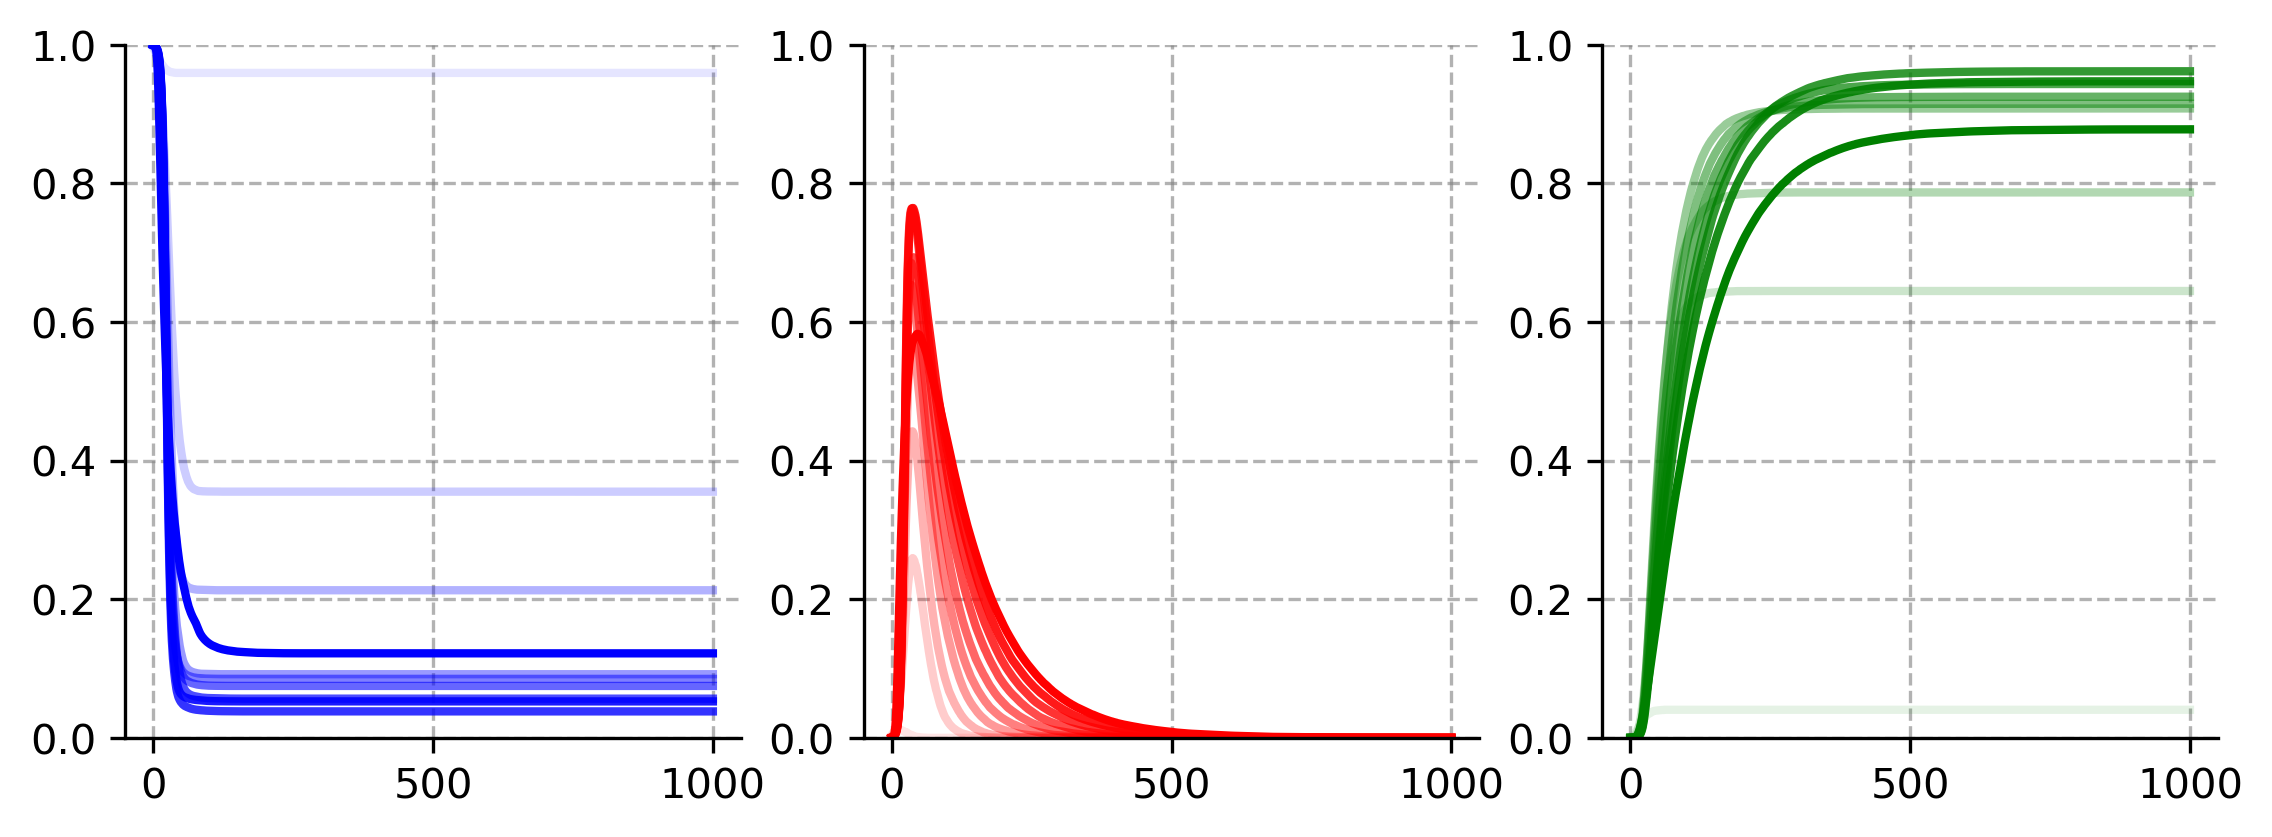

In [17]:
fig, axes = plt.subplots(1,3,figsize=(9,3))
for i in range(len(dirs)):
    axes[0].plot(mean_df.loc[i,'S'],alpha=fracs[i],color='b')
    axes[1].plot(mean_df.loc[i,'I'],alpha=fracs[i],color='r')
    axes[2].plot(mean_df.loc[i,'R'],alpha=fracs[i],color='g')
    
for ax in axes:
    ax.set_ylim([0,1.0])

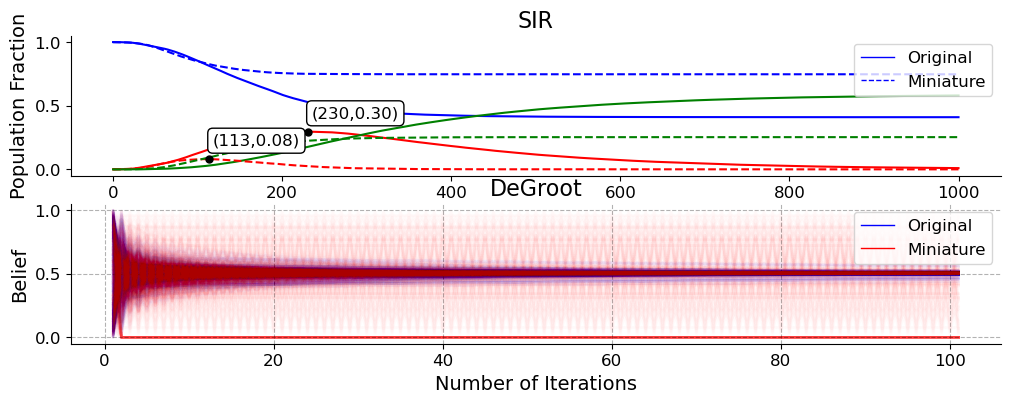

In [22]:
colors = ['b','r','g']
def plot_mean(df,ax,linestyle='-'):
    df_local = df.reset_index(names=['Run','Step'])
    group = df_local.groupby('Step').mean()
    
    for i,population in enumerate(['S','I','R']):
        ax.plot(group[population],color=colors[i],linewidth=1.5,linestyle=linestyle)
        
    # Highlight max
    y_max = group.max()['I']
    x_peak = group.idxmax()['I']
    
    ax.plot(x_peak,y_max,'ok',markersize=5)
    ax.annotate(f"({x_peak},{y_max:.2f})",
                xy=(x_peak,y_max), xycoords='data',
                xytext=(3,10), textcoords='offset points',
                bbox=dict(boxstyle='round',fc='w'))
    
    
        

def plot_trajectories(df,ax):
    indices = df.index.get_level_values(0).unique()
    
    for idx in indices:
        ax.plot(df.loc[idx]['S'],alpha=0.2,color='b')
        ax.plot(df.loc[idx]['I'],alpha=0.2,color='r')
        ax.plot(df.loc[idx]['R'],alpha=0.2,color='g')
        
def plot_dg(df,ax,color,alpha=0.005):
    x = (np.arange(df.shape[0]) + 1).astype(int)
    y = df.to_numpy()
    ax.plot(x,y,alpha=alpha,color=color)
    

fig, axes = plt.subplots(2,figsize=(12,4))

# Plot SIR
plot_mean(original_sir_df, axes[0])
plot_mean(mini_sir_df, axes[0],linestyle='--')
axes[0].set_ylabel("Population Fraction")
axes[0].set_title("SIR")
axes[0].grid(False)

custom_lines = [
    Line2D([0], [0], color='blue', lw=1.0),  # Example line 1 with blue color and linewidth 2
    Line2D([0], [0], color='blue',linestyle='--', lw=1.0)    # Example line 2 with red color and linewidth 3
]
axes[0].legend(custom_lines,['Original','Miniature'],loc='upper right')

# Plot DeGroot
plot_dg(original_dg_df.loc[0],axes[1],color='b',alpha=0.005)
plot_dg(mini_dg_df.loc[0],axes[1],color='r',alpha=0.01)
axes[1].set_ylabel("Belief")
axes[1].set_title("DeGroot")
axes[1].set_xlabel("Number of Iterations")



custom_lines = [
    Line2D([0], [0], color='blue', lw=1.0),  # Example line 1 with blue color and linewidth 2
    Line2D([0], [0], color='red', lw=1.0)    # Example line 2 with red color and linewidth 3
]

# Add the custom legend
axes[1].legend(custom_lines, ['Original', 'Miniature'],loc='upper right')
        
    
    